In [2]:
# 1. Import Libraries
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 2. Set Data Paths
data_dir = '/kaggle/input/dog-disease/dog'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

# 3. Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 4. Load Datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=2)

# 5. Define the Model (Transfer Learning with ResNet50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3),  
    nn.LogSoftmax(dim=1)
)

model.to(device)

# 6. Loss Function & Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 5

# 7. Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            val_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    print(f"Train Loss: {running_loss/len(train_loader):.3f} | "
          f"Val Loss: {val_loss/len(valid_loader):.3f} | "
          f"Val Accuracy: {accuracy/len(valid_loader):.3f}")

# 8. Save the Model
torch.save(model.state_dict(), "dog_disease_model.h5")
print("Model saved as dog_disease_model.h5")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s] 
Epoch 1/5: 100%|██████████| 145/145 [00:24<00:00,  6.02it/s]


Train Loss: 0.309 | Val Loss: 0.106 | Val Accuracy: 0.963


Epoch 2/5: 100%|██████████| 145/145 [00:20<00:00,  7.22it/s]


Train Loss: 0.144 | Val Loss: 0.120 | Val Accuracy: 0.957


Epoch 3/5: 100%|██████████| 145/145 [00:18<00:00,  7.92it/s]


Train Loss: 0.139 | Val Loss: 0.065 | Val Accuracy: 0.976


Epoch 4/5: 100%|██████████| 145/145 [00:19<00:00,  7.61it/s]


Train Loss: 0.112 | Val Loss: 0.051 | Val Accuracy: 0.980


Epoch 5/5: 100%|██████████| 145/145 [00:19<00:00,  7.39it/s]


Train Loss: 0.148 | Val Loss: 0.055 | Val Accuracy: 0.977
Model saved as dog_disease_model.pth


In [3]:
# Test Evaluation
model.eval()
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_acc += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Accuracy: {test_acc/len(test_loader):.3f}")


Test Accuracy: 0.981


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]
Epoch 1/5: 100%|██████████| 145/145 [00:24<00:00,  5.85it/s]


Epoch 1/5 => Train Loss: 0.362 | Train Acc: 0.861 | Val Loss: 0.159 | Val Acc: 0.950


Epoch 2/5: 100%|██████████| 145/145 [00:18<00:00,  7.66it/s]


Epoch 2/5 => Train Loss: 0.173 | Train Acc: 0.937 | Val Loss: 0.098 | Val Acc: 0.963


Epoch 3/5: 100%|██████████| 145/145 [00:19<00:00,  7.44it/s]


Epoch 3/5 => Train Loss: 0.147 | Train Acc: 0.951 | Val Loss: 0.075 | Val Acc: 0.979


Epoch 4/5: 100%|██████████| 145/145 [00:18<00:00,  7.76it/s]


Epoch 4/5 => Train Loss: 0.103 | Train Acc: 0.964 | Val Loss: 0.056 | Val Acc: 0.978


Epoch 5/5: 100%|██████████| 145/145 [00:18<00:00,  7.85it/s]


Epoch 5/5 => Train Loss: 0.089 | Train Acc: 0.967 | Val Loss: 0.090 | Val Acc: 0.966
Model saved as dog_disease_model.h5


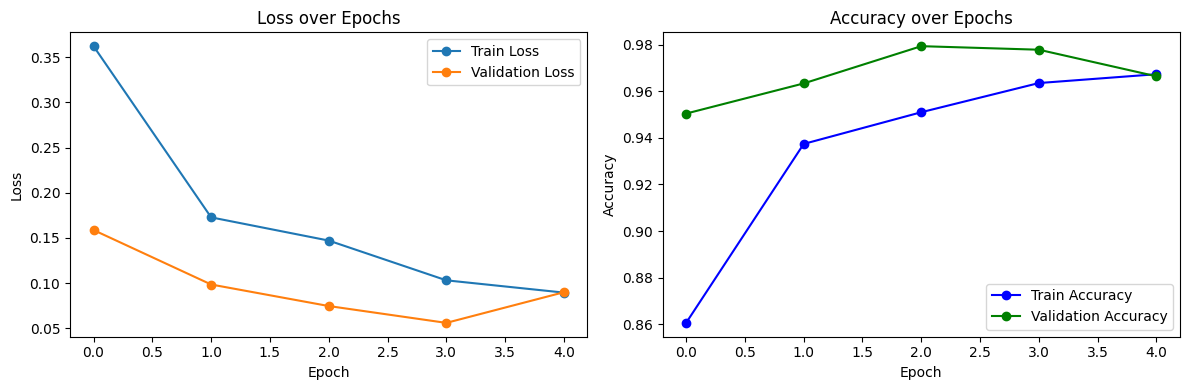

In [1]:
# 1. Import Libraries
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 2. Set Data Paths
data_dir = '/kaggle/input/dog-disease/dog'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

# 3. Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 4. Load Datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=2)

# 5. Define the Model (Transfer Learning with ResNet50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3),  # 3 classes: keratosis, nasal_discharge, skin_lesions
    nn.LogSoftmax(dim=1)
)

model.to(device)

# 6. Loss Function & Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 5

# Initialize history lists
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []


# 7. Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_accuracy = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            val_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    train_loss = running_loss / len(train_loader)
    val_loss_avg = val_loss / len(valid_loader)
    train_acc_avg = train_accuracy / len(train_loader)
    val_acc_avg = val_accuracy / len(valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss_avg)
    train_accuracies.append(train_acc_avg)
    val_accuracies.append(val_acc_avg)

    print(f"Epoch {epoch+1}/{epochs} => "
          f"Train Loss: {train_loss:.3f} | "
          f"Train Acc: {train_acc_avg:.3f} | "
          f"Val Loss: {val_loss_avg:.3f} | "
          f"Val Acc: {val_acc_avg:.3f}")


            

# 8. Save the Model
torch.save(model.state_dict(), "dog_disease_model.h5")
print("Model saved as dog_disease_model.h5")

# 9. Plot Training History
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()
